In [1]:
import numpy as np

from brodatz.data_utils import process_file, process_file_some_classes, read_some_classes, save_model, read_train_test_sets, save_history
from brodatz.utils import probas_to_classes, accuracy, curr_date
from brodatz.visualization_utils import plot_image, plot, plot_history, plot_confusion_matrix, plot_inputs

from brodatz.models.keras_neural_net import KerasNeuralNetwork

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from keras import regularizers, optimizers, utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# remove prefixes
import os
path = '/mnt/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/01_data_cls'
os.chdir(path)

In [ ]:
classes_range = np.arange(0, 20)
X_train, y_train, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes_range)

In [ ]:
classes_range = np.arange(0, 20)
X_train, y_train, num_classes = read_some_classes('Alexander_cls_train.csv', classes_range)

In [ ]:
plot_image(X_mean)

In [ ]:
plot_image(X_train[10])

In [ ]:
classes_range = np.arange(0, 20)
X_train, y_train, num_classes = read_some_classes('Alexander_cls_train.csv', classes_range)
X_test, y_test, num_classes = read_some_classes('Alexander_cls_test.csv', classes_range)

X_train = X_train.astype('float') / 255
X_mean = np.mean(X_train, axis=0)
# X_std = np.std(X_train, axis=0)
# X_train = (X_train - X_mean) / (X_std + 1e-7)
X_train -= X_mean

X_test = X_test.astype('float') / 255
# X_test = (X_test - X_mean) / (X_std + 1e-7)
X_test -= X_mean
X_test = X_test[..., np.newaxis]

y_train = utils.to_categorical(y_train, num_classes=num_classes)
X_train = X_train[..., np.newaxis]

mask = np.random.permutation(len(X_test))
# X_train = X_train[mask]
# y_train = y_train[mask]
num_train = round(len(X_test) * 0.8)
X_val = X_test[num_train:]
y_val = y_test[num_train:]
y_val = utils.to_categorical(y_val, num_classes=num_classes)

# num_train = round(len(X_train) * 0.8)
# X_val = X_train[num_train:]
# y_val = y_train[num_train:]
# X_train = X_train[:num_train]
# y_train = y_train[:num_train]

In [16]:
train_filename = 'Alexander_cls_train.csv'
test_filenames = ['Alexander_cls_test.csv',
                  'Alexander_cls_test1.csv',
                  'Alexander_cls_test2.csv',
                  'Alexander_cls_test3.csv',
                  'Alexander_cls_test4.csv']
classes_range = np.arange(0, 111)
X_train, y_train, num_classes, X_val, y_val, test_list = read_train_test_sets(train_filename, test_filenames, classes_range)

In [7]:
class_number = 5
mask = np.argmax(y_train, axis=1) == class_number
X_train_cls = X_train[mask]

test_list_cls = [test[0][np.argmax(test[1], axis=1) == class_number] for test in test_list]
test_list_cls = [X_train_cls] + test_list_cls[1:]

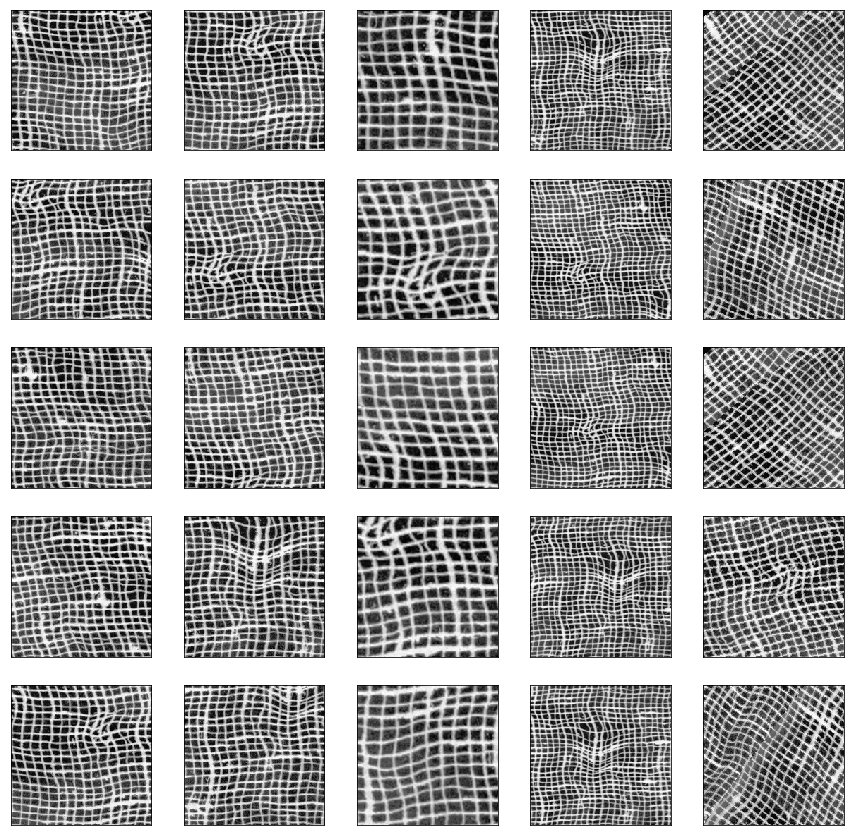

In [9]:
plot_inputs(test_list_cls)

In [17]:
X_val, y_val = test_list[2][:2]

In [26]:
import json
import pandas as pd
import datetime

def try_args(rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode,
             batch_size, epochs, learning_rate, regularization_strength):
    input_shape = X_train[0].shape
    
    learning_rate = learning_rate
    regularizer = regularizers.l2(regularization_strength)
    optimizer = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
   
    net = KerasNeuralNetwork(input_shape, num_classes, regularizer=regularizer, optimizer=optimizer)
    net.compile_model_3()
    
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        shear_range=np.pi * shear_range,
        width_shift_range=shift_range,
        height_shift_range=shift_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        zoom_range=zoom_range,
        fill_mode=fill_mode)
    
    train_start = datetime.datetime.now()
    history = net.train(datagen, X_train, y_train, (X_val, y_val), epochs=epochs, batch_size=batch_size,)
    train_finish = datetime.datetime.now()
    train_duration = (train_finish - train_start).seconds
    
    model_name = curr_date() # name of the directory for model
    root_directory = '/home/stanislau/repository/machine-learning/brodatz/results/'
    directory_name = root_directory + curr_date()
    if not os.path.exists(directory_name):
        os.makedirs(directory_name) # create directory
        
    save_history(directory_name + '/loss.png', directory_name + '/accuracy.png', history) # save plots of loss and accuracy
        
    model_json = net.model.to_json()
    with open(directory_name + "/model.json", "w") as json_file:
        json_file.write(model_json) # save model to file
        
    utils.plot_model(net.model, to_file=directory_name + "/model.png", show_shapes=True) # save model png overview to file
    
    count_params = net.model.count_params() # number of model parameters
    optimizer_json = json.dumps(optimizers.serialize(optimizer))
    with open(directory_name + "/optimizer.json", "w") as json_file:
        json_file.write(optimizer_json) # save optimizer to file

    models_battles_filename = root_directory + 'models_battles.csv'
    header = ['Model name', 'X_train', 'X_test', 'X_test1', 'X_test2', 'X_test3', 'X_test4',
              'Epochs', 'Number of parameters', 'Batches', 'Learning rate', 'Train duration',
              'Rotation range', 'Shear range', 'Shift range', 'Hor flip', 'Ver flip', 'Zoom range', 'Fill mode',
              'Number of classes',
              'Regularization Strength']
    accuracies = [net.accuracy(X_test, y_test) for X_test, y_test, _ in [(X_train, y_train, num_classes)] + test_list]
    data = [model_name]
    data.extend(accuracies)
    number_of_params = net.model.count_params()
    data.extend([epochs, number_of_params, batch_size, learning_rate, train_duration])
    data.extend([rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode])
    data.append(num_classes)
    data.append(regularization_strength)
    if not os.path.isfile(models_battles_filename):
        df = pd.DataFrame([data], columns=header)
        df.to_csv(models_battles_filename)
    else:
        with open(models_battles_filename, 'a') as f:
            df = pd.DataFrame([data])
            df.to_csv(f, header=False)

rotation_ranges = [0, 45, 90, 135, 180]
shear_ranges = [0, 0.2, 0.25, 1/3, 0.5, 0.75, 1]
shift_ranges = [0, 0.15, 0.2, 0.3, 0.4, 0.45]
horizontal_flips = [True, False]
vertical_flips = [True, False]
zoom_ranges = [0, 0.2, 0.35, 0.5, 0.7, [0.55, 0.65], [0.6, 0.7]]
fill_modes = ['reflect', 'nearest', 'wrap']
learning_rates = [0.001, 0.002, 0.005, 0.01]
regularization_strengths = [0.001, 0.01, 0.05, 0.1]

rotation_range = rotation_ranges[0]
shear_range = shear_ranges[0]
shift_range = shift_ranges[2]
horizontal_flip = horizontal_flips[1]
vertical_flip = vertical_flips[1]
zoom_range = zoom_ranges[5]
fill_mode = fill_modes[0]
batch_size = 64
epochs = 1000
learning_rate = learning_rates[1]
regularization_strength = regularization_strengths[1]


for zoom_range in zoom_ranges:
    for shift_range in shift_ranges:
        for flip in [True, False]:
            horizontal_flip = flip
            vertical_flip = flip
        
            try_args(rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode, batch_size, epochs, learning_rate, regularization_strength)

# for shear_range in shear_ranges:
#     try_args(rotation_range, shear_range, shift_range, horizontal_flip, vertical_flip, zoom_range, fill_mode, batch_size, epochs)

Epoch 1/250
9/8 [===============================] - 2s 202ms/step - loss: 8.2164 - acc: 0.0070 - val_loss: 8.1896 - val_acc: 0.0108
Epoch 2/250
9/8 [===============================] - 1s 129ms/step - loss: 8.1672 - acc: 0.0095 - val_loss: 8.1337 - val_acc: 0.0126
Epoch 3/250
9/8 [===============================] - 1s 146ms/step - loss: 8.1074 - acc: 0.0052 - val_loss: 8.0701 - val_acc: 0.0090
Epoch 4/250
9/8 [===============================] - 1s 139ms/step - loss: 8.0400 - acc: 0.0147 - val_loss: 8.0037 - val_acc: 0.0180
Epoch 5/250
9/8 [===============================] - 1s 150ms/step - loss: 7.9725 - acc: 0.0174 - val_loss: 7.9358 - val_acc: 0.0162
Epoch 6/250
9/8 [===============================] - 1s 152ms/step - loss: 7.9029 - acc: 0.0105 - val_loss: 7.8677 - val_acc: 0.0144
Epoch 7/250
9/8 [===============================] - 1s 147ms/step - loss: 7.8329 - acc: 0.0164 - val_loss: 7.7962 - val_acc: 0.0216
Epoch 8/250
9/8 [===============================] - 1s 142ms/step - loss: 7.

Epoch 63/250
9/8 [===============================] - 1s 150ms/step - loss: 2.6852 - acc: 0.7531 - val_loss: 3.2345 - val_acc: 0.6306
Epoch 64/250
9/8 [===============================] - 1s 147ms/step - loss: 2.6227 - acc: 0.7616 - val_loss: 3.2017 - val_acc: 0.6216
Epoch 65/250
9/8 [===============================] - 1s 146ms/step - loss: 2.5523 - acc: 0.7727 - val_loss: 3.3751 - val_acc: 0.5964
Epoch 66/250
9/8 [===============================] - 1s 145ms/step - loss: 2.5800 - acc: 0.7670 - val_loss: 3.1555 - val_acc: 0.6396
Epoch 67/250
9/8 [===============================] - 1s 145ms/step - loss: 2.4601 - acc: 0.7840 - val_loss: 3.0454 - val_acc: 0.6631
Epoch 68/250
9/8 [===============================] - 1s 150ms/step - loss: 2.3950 - acc: 0.8072 - val_loss: 3.1009 - val_acc: 0.6577
Epoch 69/250
9/8 [===============================] - 1s 152ms/step - loss: 2.4087 - acc: 0.8231 - val_loss: 3.1209 - val_acc: 0.6613
Epoch 70/250
9/8 [===============================] - 1s 128ms/step - 

9/8 [===============================] - 1s 155ms/step - loss: 1.6745 - acc: 0.8637 - val_loss: 2.4026 - val_acc: 0.6829
Epoch 125/250
9/8 [===============================] - 1s 141ms/step - loss: 1.5792 - acc: 0.9009 - val_loss: 2.2770 - val_acc: 0.7189
Epoch 126/250
9/8 [===============================] - 1s 144ms/step - loss: 1.5171 - acc: 0.9104 - val_loss: 2.2224 - val_acc: 0.7135
Epoch 127/250
9/8 [===============================] - 1s 147ms/step - loss: 1.5286 - acc: 0.9009 - val_loss: 2.1910 - val_acc: 0.7261
Epoch 128/250
9/8 [===============================] - 1s 153ms/step - loss: 1.6200 - acc: 0.8787 - val_loss: 2.2062 - val_acc: 0.7207
Epoch 129/250
9/8 [===============================] - 1s 132ms/step - loss: 1.4542 - acc: 0.9212 - val_loss: 2.1838 - val_acc: 0.7243
Epoch 130/250
9/8 [===============================] - 1s 151ms/step - loss: 1.4673 - acc: 0.9272 - val_loss: 2.2028 - val_acc: 0.7315
Epoch 131/250
9/8 [===============================] - 1s 159ms/step - loss: 

9/8 [===============================] - 1s 148ms/step - loss: 1.2553 - acc: 0.9116 - val_loss: 1.8117 - val_acc: 0.7550
Epoch 186/250
9/8 [===============================] - 1s 138ms/step - loss: 1.1870 - acc: 0.9297 - val_loss: 1.8213 - val_acc: 0.7441
Epoch 187/250
9/8 [===============================] - 1s 146ms/step - loss: 1.2064 - acc: 0.9377 - val_loss: 1.8427 - val_acc: 0.7676
Epoch 188/250
9/8 [===============================] - 1s 146ms/step - loss: 1.2066 - acc: 0.9195 - val_loss: 1.9673 - val_acc: 0.7459
Epoch 189/250
9/8 [===============================] - 1s 145ms/step - loss: 1.2546 - acc: 0.9102 - val_loss: 1.9445 - val_acc: 0.7135
Epoch 190/250
9/8 [===============================] - 1s 145ms/step - loss: 1.1694 - acc: 0.9297 - val_loss: 1.7784 - val_acc: 0.7784
Epoch 191/250
9/8 [===============================] - 1s 144ms/step - loss: 1.2015 - acc: 0.9290 - val_loss: 2.0374 - val_acc: 0.7387
Epoch 192/250
9/8 [===============================] - 1s 150ms/step - loss: 

9/8 [===============================] - 1s 151ms/step - loss: 1.0256 - acc: 0.9499 - val_loss: 1.7936 - val_acc: 0.7405
Epoch 247/250
9/8 [===============================] - 1s 142ms/step - loss: 1.1260 - acc: 0.9193 - val_loss: 1.7978 - val_acc: 0.7369
Epoch 248/250
9/8 [===============================] - 1s 153ms/step - loss: 1.1029 - acc: 0.9325 - val_loss: 1.7693 - val_acc: 0.7495
Epoch 249/250
9/8 [===============================] - 1s 138ms/step - loss: 1.1218 - acc: 0.9238 - val_loss: 1.7187 - val_acc: 0.7441
Epoch 250/250
9/8 [===============================] - 1s 157ms/step - loss: 1.0659 - acc: 0.9360 - val_loss: 1.7326 - val_acc: 0.7568


In [28]:
shift_ranges[2:5]

[0.2, 0.3, 0.4]

In [ ]:
input_shape = (200, 200, 1)

learning_rate = 0.01

regularizer = regularizers.l2(0.01)
optimizer = optimizers.SGD(lr=learning_rate, decay=1e-7, momentum=0.9, nesterov=True)
# optimizer = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

net = KerasNeuralNetwork(input_shape, num_classes, regularizer=regularizer, optimizer=optimizer)
net.compile_model_6()

In [ ]:
history = net.train(X_train, y_train, (X_val, y_val), epochs=100, batch_size=256, )

In [ ]:
plot_history(history)

In [ ]:
net.model.summary()

In [ ]:
model_name = curr_date()

In [ ]:
root_directory = '/home/stanislau/repository/machine-learning/brodatz/results/'
directory_name = root_directory + curr_date()

In [ ]:
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

In [ ]:
model_json = net.model.to_json()
with open(directory_name + "/model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
utils.plot_model(net.model, to_file=directory_name + "/model.png", show_shapes=True)

In [ ]:
accuracies = [net.accuracy(X_test, y_test) for X_test, y_test, _ in [(X_train, y_train, num_classes)] + test_list]

In [ ]:
accuracies